<a href="https://colab.research.google.com/github/law0/face_detect/blob/main/face_detect_resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [324]:
req = """# Python 3.7.5
onnx>=1.7.0
numpy>=1.19.1

torch>=1.8.1
torchvision>=0.6.1

tensorflow>=2.1.0
tensorflow-gpu>=2.1.0"""

f = open("requirements.txt", "w")
f.write(req)
f.close()

In [325]:
!pip install -r requirements.txt

In [326]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import widerface
import tensorflow_datasets.public_api as tfds
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import os
import copy
import pandas
import requests
import zipfile
from math import ceil
from math import floor
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.8.1+cu101
Torchvision Version:  0.9.1+cu101


In [327]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [328]:
torch.manual_seed(1)

In [329]:
batch_size_train = 10
batch_size_test = 1
num_classes = 1
num_cells = 49
num_boxes_per_cell = 3
img_dim = 224
epochs = 20

def detection_collate(batch):
  """Custom collate fn for dealing with batches of images that have a different
  number of associated object annotations (bounding boxes).
  Arguments:
      batch: (tuple) A tuple of tensor images and lists of annotations
  Return:
      A tuple containing:
          1) (tensor) batch of images stacked on their 0 dim
          2) (list of tensors) annotations for a given image are stacked on 0 dim
  """
  transform_resize = transforms.Resize((img_dim, img_dim))
  targets = []
  imgs = []
  for _, sample in enumerate(batch):
    img, annot = sample
    target = torch.tensor(annot['bbox']).float()
    if target.shape[0] < 11: #drop images with too many targets : too hard
      orig_h = img.shape[1]
      orig_w = img.shape[2]
      img = transform_resize(img)
      
      target[:,0] = target[:,0] / orig_w * img_dim
      target[:,2] = target[:,2] / orig_w * img_dim

      target[:,1] = target[:,1] / orig_h * img_dim
      target[:,3] = target[:,3] / orig_h * img_dim

      mt = torch.mean(target, dim=0)
      if mt[2] * mt[3] > 400: # drop images with too small targets (w*h < 20*20)
        imgs.append(img)
        targets.append(target)

  imgs_t = None
  targets_t = None
  if len(imgs) > 0 and len(targets) > 0:
    imgs_t = torch.stack(imgs, 0)
    targets_t = targets

  return (imgs_t, targets_t)

In [330]:
train_loader = torch.utils.data.DataLoader(
  datasets.WIDERFace('./', "train", download=True,
                             transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
                             ])),
  batch_size=batch_size_train, shuffle=True, collate_fn=detection_collate)

val_loader = torch.utils.data.DataLoader(
  datasets.WIDERFace('./', "val", download=True,
                              transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
                             ])),
  batch_size=batch_size_train, shuffle=True, collate_fn=detection_collate)

test_loader = torch.utils.data.DataLoader(
  datasets.WIDERFace('./', "test", download=True,
                             transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
                             ])),
  batch_size=batch_size_test, shuffle=True, collate_fn=detection_collate)



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


79.40625 49.4196662902832 19.25 54.25419616699219
120.3125 47.27098083496094 17.71875 53.71702575683594
132.5625 29.007192611694336 13.5625 40.8249397277832


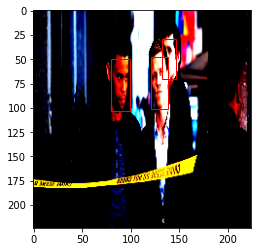

In [331]:
images = None
targets = None

while images is None or targets is None:
  images, targets = next(iter(train_loader))

fig, ax = plt.subplots()

ax.imshow(images[0].permute(1, 2, 0))

num_targets = targets[0].shape[0]
for i in range(num_targets):
  #x,y represent bottom left corner
  x = targets[0][i][0]
  y = targets[0][i][1]
  w = targets[0][i][2]
  h = targets[0][i][3]
  print("{} {} {} {}".format(x, y, w, h))
  rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')

  # Add the patch to the Axes
  ax.add_patch(rect)

plt.show()

In [332]:
def intersect(box_a, box_b):
    """ 
    We compute the area of intersect between box_a and box_b.
    Args:
      box_a: (tensor) bounding boxes, Shape: [A,4].
      box_b: (tensor) bounding boxes, Shape: [B,4].
    Return:
      (tensor) intersection area, Shape: [A,B].
    """

    max_xy = torch.min(box_a[:, 2:] + box_a[:, :2], box_b[:, 2:] +  box_b[:, :2])
    min_xy = torch.max(box_a[:, :2], box_b[:, :2])

    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, 0] * inter[:, 1]


def jaccard(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
    is simply the intersection over union of two boxes.  Here we operate on
    ground truth boxes and default boxes.
    E.g.:
        A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    Args:
        box_a: (tensor) Ground truth bounding boxes, Shape: [num_objects,4]
        box_b: (tensor) Pred box Shape: [4]
    Return:
        
    """
    inter = intersect(box_a, box_b)
    area_a = box_a[:, 2] * box_a[:, 3]  # [A,B]
    area_b = box_b[:, 2] * box_b[:, 3]  # [A,B]
    union = area_a + area_b - inter
    return inter / (union + 1e-10)  # [A,B]

In [333]:
def index_select_2D(input, dim, indexes, by=1):
  """
    like index_select but with indexes with more than one dim
    example :
      x=torch.randn((2,3,2))
      i = torch.randint(2, (2,3,1))
      index_select_2D(x, -1, i)
      will select in the last dimension (2) with the value in i
      and output a tensor of shape (2, 3)

      x=torch.randn((2,3,2,4))
      i = torch.randint(2, (2,3,1))
      index_select_2D(x, -2, i, by=4)
      will select (whole row, 4 by 4) along the dimension (2) with the value in i
      and output a tensor of sh, ape (2, 3, 4)

      NOTE : indexes must have the same number of dimension as input
  """
  if by > 1:
    indexes = torch.stack([indexes]*by, dim=-1)
  return torch.gather(input, dim, indexes).squeeze()


In [334]:
class ResnetGrid7x7(nn.Module):
    def __init__(self, resnet=models.resnet18(pretrained=True)):
      super(ResnetGrid7x7, self).__init__()
      self.resnet = resnet
      self.resnet.fc = nn.Linear(512, num_cells*(num_classes+num_boxes_per_cell*5)) # 7 * 7 * (class + 2 * (x,y,w,h + confidence))
      self.sigmo = nn.Sigmoid()
      
    def forward(self, x):
      return self.sigmo(self.resnet(x))
    
    def train(self, mode: bool=True):
      self.resnet.train(mode)

    def eval(self):
      self.resnet.eval()

    def freeze_resnet(self, mode: bool=True):
      for param in self.resnet.parameters():
        param.require_grad = not mode


In [335]:
class PseudoYolo7x7Loss(nn.Module):
    def __init__(self, noobj_w=1.0, class_w=1.0, conf_w=1.0, box_w=1.0):
      super(PseudoYolo7x7Loss, self).__init__()
      self.class_w = class_w
      self.conf_w = conf_w
      self.box_w = box_w
      self.noobj_w = noobj_w
      self.sse_loss = nn.MSELoss()
      self.bce_loss = nn.BCELoss()
      
      #Coords of each cells
      self.cell_x = torch.empty(num_cells).int().to(device)
      self.cell_y = torch.empty(num_cells).int().to(device)
      for i in range(num_cells):
        self.cell_x[i] = floor(i % 7) * 32
        self.cell_y[i] = floor(i / 7) * 32


    def getResponsibleCells(self, targets):
      """  
        return a tuple of tensor:
        - is_responsible, of size (batch_size, num_targets, num_cells)
          which contain the target confidence (0 or 1) for each cell (basically if
          the cell is responsible of at least one target bounding box, it will have a 1)
        - targets_box of size (batch_size, num_cells, 4)
          which contains for each cell, the target bounding box it is responsible of
      """

      batch_size = len(targets)

      # This limit the number of,  detectable targets to the first 10 targets
      num_lim_targets = 10
      lim_targets = - torch.ones(batch_size, num_lim_targets, 4).float().to(device)
      for b in range(batch_size):
        num_targets = targets[b].shape[0]
        # even with overflow index, pytorch doesn't error, good
        lim_targets[b, :num_targets] = targets[b][:num_lim_targets]

      # Calculates centers of target boxes
      center_xs = lim_targets[:, :, 0] + lim_targets[:, :, 2]/2
      center_ys = lim_targets[:, :, 1] + lim_targets[:, :, 3]/2
      # make it broadcastable with cell_x and cell_y
      center_xs = center_xs.unsqueeze(2).expand(-1, -1, num_cells)
      center_ys = center_ys.unsqueeze(2).expand(-1, -1, num_cells)

      # is_responsible contains for each targets (rows) if cells is responsible (columns)
      is_responsible_x = torch.logical_and(self.cell_x <= center_xs, center_xs <= self.cell_x + 32)
      is_responsible_y = torch.logical_and(self.cell_y <= center_ys, center_ys <= self.cell_y + 32)
      is_responsible = torch.logical_and(is_responsible_x, is_responsible_y)  

      # https://pytorch.org/docs/stable/generated/torch.nonzero.html
      batch_indexes,target_indexes,cell_indexes = is_responsible.nonzero(as_tuple=True)

      #resize to range [0. 1.]
      lim_targets = lim_targets / img_dim

      # batch_size * (49 rows of (.5,.5,.5,.5))
      targets_boxes = torch.tensor((.5,.5,.5,.5)).expand((batch_size, num_cells, 4)).to(device)
      # Pytorch indexing is just magical...
      targets_boxes[batch_indexes, cell_indexes, :] = lim_targets[batch_indexes, target_indexes, :]

      #(batch_size, num_targets, num_cells) (batch_size, num_cells, 4)
      return is_responsible, targets_boxes

    def sqrtAndCenterOffsetBoxes(self, preds_boxes, targets_boxes):
      preds_boxes_xy, preds_boxes_wh = torch.split(preds_boxes, 2, dim=-1)
      targets_boxes_xy, targets_boxes_wh = torch.split(targets_boxes, 2, dim=-1)

      # predict box center_x, center_y relative to cell_x, and cell_y
      cell_xy = torch.stack([self.cell_x, self.cell_y], dim=-1)
      targets_centers = (targets_boxes_xy + targets_boxes_wh / 2.)
      targets_boxes_xy =  targets_centers - cell_xy / 32.

      # predict square root of w and h. Otherwise loss function would advantage
      # small boxes
      preds_boxes_wh = preds_boxes_wh.sqrt()
      targets_boxes_wh = targets_boxes_wh.sqrt()

      # reunite
      preds_boxes = torch.cat([preds_boxes_xy, preds_boxes_wh], dim=-1)
      targets_boxes = torch.cat([targets_boxes_xy, targets_boxes_wh], dim=-1)

      return preds_boxes, targets_boxes


    def forward(self, predictions, targets):
      preds = predictions.view(-1, num_cells, num_classes+num_boxes_per_cell*5)
      batch_size = preds.shape[0]

      # (batch, cells, (class + boxes * (x,y,w,h + confidence))
      preds_class = preds[:,:,0] #(batch, cells, class(1))
      preds_conf_and_boxes = preds[:,:,1:].view(-1, num_cells, num_boxes_per_cell, 5)
      preds_confs = preds_conf_and_boxes[:, :, :, 0] #(batch, cells, boxes)
      preds_boxes = preds_conf_and_boxes[:, :, :, 1:] #(batch, cells, boxes, 4)

      # print("A ", preds_confs.shape, preds_boxes.shape)

      is_responsible, targets_boxes = self.getResponsibleCells(targets)

      ious = []
      for i in range(num_boxes_per_cell):
        pb = preds_boxes[:,:,i,:]
        iou_bi = jaccard(targets_boxes.view(-1, 4), pb.contiguous().view(-1, 4))
        iou_bi = iou_bi.view(targets_boxes.shape[0], targets_boxes.shape[1]) #(batch, cells)
        ious.append(iou_bi)
      iou = torch.stack(ious, dim=-1) #(batch, cells, boxes)

      max_iou_indexes = torch.argmax(iou, dim=-1, keepdim=True)

      # print("max ", max_iou_indexes.shape)

      # For each cell, select the box and conf with max IoU
      preds_confs = index_select_2D(preds_confs, -1, max_iou_indexes)
      preds_boxes = index_select_2D(preds_boxes, -2, max_iou_indexes, by=4)

      # print("B ", preds_confs.shape, preds_boxes.shape)

      # w, h are to be evaluated to their sqrt (advantages little boxes otherwise)
      # preds x, y are to be evaluated as center of box and relative to the cell x,y
      preds_boxes, targets_boxes = self.sqrtAndCenterOffsetBoxes(preds_boxes, targets_boxes)

      # calculate box loss only for if a the cell is responsible. This zeros the loss otherwise
      cr_reduced = (torch.sum(is_responsible, 1) > 0).float()
      targets_boxes.masked_scatter_(torch.logical_not(cr_reduced.bool()).unsqueeze(-1).expand_as(targets_boxes),
                                      preds_boxes)

      # If an object is not detected, weight down the conf loss
      cr_reduced.masked_scatter_(torch.logical_not(cr_reduced.bool()), cr_reduced * self.noobj_w).float()

      class_loss = self.sse_loss(preds_class.squeeze(), cr_reduced.detach().squeeze())
      box_loss = self.sse_loss(preds_boxes.squeeze(), targets_boxes.squeeze())
      conf_loss = self.sse_loss(preds_confs.squeeze(), cr_reduced.detach().squeeze())


      return self.class_w * class_loss + self.box_w * box_loss + self.conf_w * conf_loss

----- epoch  0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.6562
class 0.8286888003349304, confidence 0.45028433203697205, box: 98.48041534423828 53.550048828125 152.4235382080078 128.38064575195312
class 0.8286888003349304, confidence 0.5260820388793945, box: 127.99533081054688 46.58600616455078 82.21633911132812 151.5359344482422
class 0.8286888003349304, confidence 0.6016899347305298, box: 149.1250762939453 96.45687866210938 53.996490478515625 41.75308609008789
class 0.779313325881958, confidence 0.48601314425468445, box: -14.903526306152344 18.018726348876953 52.375160217285156 108.34680938720703
class 0.779313325881958, confidence 0.290182888507843, box: -34.70615768432617 23.165855407714844 99.46302032470703 106.72415161132812
class 0.779313325881958, confidence 0.26589640974998474, box: -32.675254821777344 12.68328857421875 99.32528686523438 132.08319091796875
class 0.7317704558372498, confidence 0.33087465167045593, box: 23.943382263183594 89.16720581054688 110.94050598144531 115.06501007080078
class 0.7317704558372498, confidence 0.4

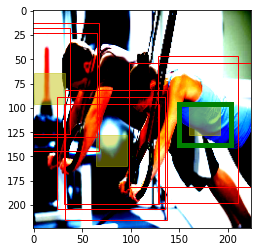

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.1313
class 0.8124555349349976, confidence 0.5571033954620361, box: -39.45748519897461 7.3611297607421875 107.24627685546875 137.24591064453125
class 0.8124555349349976, confidence 0.2766176462173462, box: -37.519012451171875 -1.3103790283203125 96.51079559326172 150.94577026367188
class 0.8124555349349976, confidence 0.2570488750934601, box: -44.126609802246094 30.949569702148438 129.6944580078125 98.28215026855469
class 0.747579038143158, confidence 0.6756148934364319, box: -11.314617156982422 136.45034790039062 116.0387191772461 73.3182144165039
class 0.747579038143158, confidence 0.2299361526966095, box: -32.81427001953125 144.47622680664062 176.55125427246094 82.4281005859375
class 0.747579038143158, confidence 0.27993208169937134, box: 1.0266952514648438 131.37684631347656 101.83869934082031 84.4418716430664
class 0.7438291907310486, confidence 0.31464698910713196, box: 19.261112213134766 78.27882385253906 123.45003509521484 133.2655029296875
class 0.7438291907310486, confidence

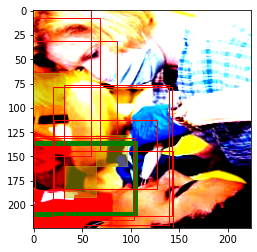

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.0040
class 0.7501388192176819, confidence 0.2960091829299927, box: 106.25367736816406 72.26748657226562 145.5645751953125 83.38294219970703
class 0.7501388192176819, confidence 0.4750899374485016, box: 131.47531127929688 51.682411193847656 76.17132568359375 137.91014099121094
class 0.7501388192176819, confidence 0.6596298217773438, box: 156.29306030273438 74.78821563720703 49.281524658203125 79.14237976074219
class 0.6469561457633972, confidence 0.3072337210178375, box: -32.52721405029297 17.56761932373047 89.11187744140625 184.78909301757812
class 0.6469561457633972, confidence 0.40558043122291565, box: -48.955787658691406 15.896026611328125 144.12301635742188 201.2826690673828
class 0.6469561457633972, confidence 0.23465777933597565, box: -39.68702697753906 60.588233947753906 119.8155746459961 85.95596313476562
class 0.6155998110771179, confidence 0.3708387315273285, box: 32.1278076171875 78.84664916992188 90.94931030273438 117.0374984741211
class 0.6155998110771179, confidence 0.4

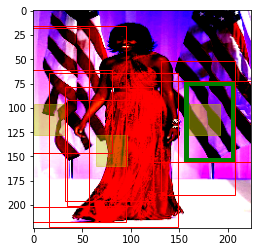

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.5798
class 0.7187845706939697, confidence 0.5216067433357239, box: 7.401893615722656 120.70742797851562 83.61328887939453 108.67678833007812
class 0.7187845706939697, confidence 0.17866067588329315, box: -9.567890167236328 137.99514770507812 131.93148803710938 93.26805114746094
class 0.7187845706939697, confidence 0.27570071816444397, box: -19.20465087890625 128.7097625732422 129.64913940429688 85.23340606689453
class 0.663007915019989, confidence 0.24471768736839294, box: 86.4966049194336 25.914348602294922 101.21669006347656 111.13973236083984
class 0.663007915019989, confidence 0.45983511209487915, box: 86.7188949584961 6.194435119628906 121.62617492675781 140.87899780273438
class 0.663007915019989, confidence 0.42149946093559265, box: 104.34646606445312 19.639266967773438 75.49922943115234 101.57843017578125
class 0.6318413615226746, confidence 0.36339032649993896, box: 129.20468139648438 140.143798828125 163.65676879882812 132.44558715820312
class 0.6318413615226746, confidence 

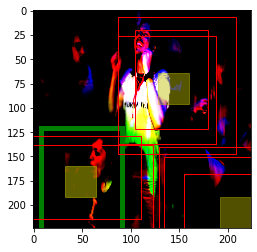

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.3501
class 0.6132097840309143, confidence 0.6549047231674194, box: -11.439571380615234 130.70814514160156 109.99026489257812 93.28701782226562
class 0.6132097840309143, confidence 0.27391937375068665, box: -12.058177947998047 150.17974853515625 133.24948120117188 66.99149322509766
class 0.6132097840309143, confidence 0.31509360671043396, box: -6.752342224121094 124.01740264892578 115.05458068847656 107.57801818847656
class 0.5577602386474609, confidence 0.385545939207077, box: -40.793975830078125 74.34658813476562 107.92555236816406 126.19677734375
class 0.5577602386474609, confidence 0.4444904625415802, box: -32.952735900878906 103.75996398925781 99.13756561279297 67.28131103515625
class 0.5577602386474609, confidence 0.41529974341392517, box: -36.66577911376953 72.4113540649414 108.73872375488281 156.5069122314453
class 0.5571991205215454, confidence 0.37971845269203186, box: 100.01798248291016 61.94322967529297 147.5504608154297 103.09861755371094
class 0.5571991205215454, confide

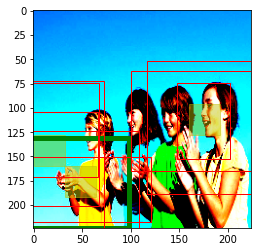

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.9617
class 0.5748611688613892, confidence 0.7515804171562195, box: 8.131256103515625 124.95291137695312 81.26692962646484 101.42060089111328
class 0.5748611688613892, confidence 0.2917068600654602, box: -19.873825073242188 136.99867248535156 153.71871948242188 95.5587387084961
class 0.5748611688613892, confidence 0.18705172836780548, box: -25.74704360961914 117.14278411865234 146.9539337158203 119.29466247558594
class 0.5556266903877258, confidence 0.235029399394989, box: 100.14959716796875 62.88612747192383 146.49179077148438 109.62236785888672
class 0.5556266903877258, confidence 0.4796438217163086, box: 113.26676940917969 49.18849182128906 115.04535675048828 143.771728515625
class 0.5556266903877258, confidence 0.42561715841293335, box: 145.19015502929688 85.15559387207031 58.11460876464844 52.72527313232422
class 0.5231315493583679, confidence 0.38638028502464294, box: 26.80260467529297 86.76152038574219 109.81733703613281 117.45782470703125
class 0.5231315493583679, confidence 0

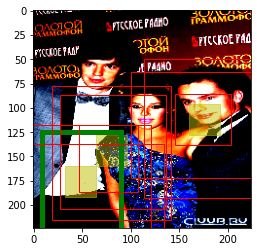

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.7998
class 0.6333438754081726, confidence 0.40669557452201843, box: 101.91410827636719 67.68719482421875 134.75732421875 91.24130249023438
class 0.6333438754081726, confidence 0.6174581050872803, box: 113.22724151611328 44.255096435546875 111.75532531738281 145.36764526367188
class 0.6333438754081726, confidence 0.5114477276802063, box: 144.71072387695312 66.27940368652344 65.1868896484375 79.6700210571289
class 0.5216989517211914, confidence 0.5782184600830078, box: 8.87807846069336 -20.59099578857422 81.21770477294922 127.24344635009766
class 0.5216989517211914, confidence 0.36596184968948364, box: -22.82532501220703 -41.182838439941406 130.54673767089844 170.31907653808594
class 0.5216989517211914, confidence 0.369731068611145, box: 7.747005462646484 -23.629905700683594 78.7353515625 140.85391235351562
class 0.451519638299942, confidence 0.37227189540863037, box: 90.98663330078125 -0.6507759094238281 96.95642852783203 87.69921112060547
class 0.451519638299942, confidence 0.2588424

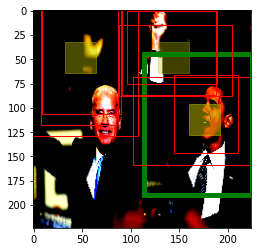

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.5972
class 0.49094969034194946, confidence 0.5359973907470703, box: 132.23696899414062 98.5127944946289 140.57705688476562 149.18089294433594
class 0.49094969034194946, confidence 0.4641692042350769, box: 122.88471984863281 143.15614318847656 160.14794921875 57.34628677368164
class 0.49094969034194946, confidence 0.39892303943634033, box: 149.6975860595703 102.55049133300781 116.3520736694336 145.98733520507812
class 0.4613723158836365, confidence 0.3187238574028015, box: 105.43518829345703 57.21039962768555 132.3465118408203 108.6689682006836
class 0.4613723158836365, confidence 0.47061842679977417, box: 110.27850341796875 47.15301513671875 117.2576904296875 141.31817626953125
class 0.4613723158836365, confidence 0.5078791379928589, box: 146.8936767578125 81.23621368408203 55.48638153076172 55.28974533081055
class 0.4296007752418518, confidence 0.3373361825942993, box: 25.56719207763672 91.95510864257812 103.47689819335938 97.46585083007812
class 0.4296007752418518, confidence 0.369

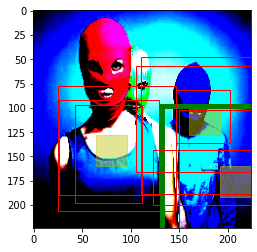

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.0720
class 0.5293118953704834, confidence 0.29930368065834045, box: 91.30640411376953 52.40718078613281 152.3531036376953 121.34225463867188
class 0.5293118953704834, confidence 0.5780002474784851, box: 123.61920928955078 34.52784729003906 88.70063781738281 168.44020080566406
class 0.5293118953704834, confidence 0.6364953517913818, box: 155.9197998046875 67.41702270507812 48.89496994018555 92.07955169677734
class 0.4698864221572876, confidence 0.6134513020515442, box: 52.89374542236328 46.4167366027832 110.53034973144531 112.66248321533203
class 0.4698864221572876, confidence 0.6469323635101318, box: 49.263031005859375 63.28876495361328 133.31674194335938 98.80239868164062
class 0.4698864221572876, confidence 0.24089457094669342, box: 59.09309005737305 60.92428207397461 108.87189483642578 106.34534454345703
class 0.4331926703453064, confidence 0.29532766342163086, box: -5.841335296630859 -4.033344268798828 105.2509765625 100.07319641113281
class 0.4331926703453064, confidence 0.33686

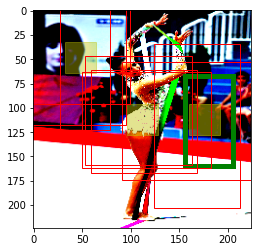

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.4515
class 0.44663727283477783, confidence 0.27141332626342773, box: 103.18505859375 52.117149353027344 139.36865234375 107.09321594238281
class 0.44663727283477783, confidence 0.4771314263343811, box: 131.07432556152344 48.76835632324219 80.81395721435547 141.4307861328125
class 0.44663727283477783, confidence 0.5801787972450256, box: 156.24349975585938 78.48483276367188 49.18773651123047 63.052711486816406
class 0.3901485204696655, confidence 0.5741068124771118, box: 85.714599609375 137.0257568359375 116.15991973876953 135.7108154296875
class 0.3901485204696655, confidence 0.20097580552101135, box: 100.64075469970703 147.38735961914062 87.02262878417969 117.46967315673828
class 0.3901485204696655, confidence 0.49935591220855713, box: 85.14732360839844 150.02403259277344 124.45673370361328 116.54769897460938
class 0.37195244431495667, confidence 0.5796931385993958, box: 128.37705993652344 108.48297119140625 96.30984497070312 125.10018920898438
class 0.37195244431495667, confidence 0

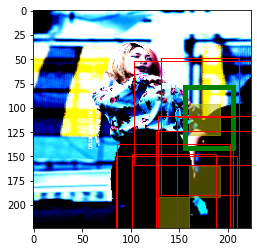

In [ ]:
model = ResnetGrid7x7()
optimizer = optim.SGD(model.parameters(), lr=1e-3, weight_decay=5e-4)
criterion = PseudoYolo7x7Loss(noobj_w=0.5, box_w=5.0, conf_w=0.5, class_w=1.0)

loss_over_time = []

model.to(device)
model.train(True)

for ep in range(epochs):
  print("----- epoch ", ep)
  for i, (images, targets) in enumerate(train_loader):
    if images is None or targets is None:
      continue
    images = images.to(device)
    targets = [anno.to(device) for anno in targets]

    optimizer.zero_grad()

    out = model(images)
    loss = criterion(out, targets)
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
      loss = loss.cpu()
      print("{:.4f}".format(loss.item()))
      loss_over_time.append(loss.item())

    #if i % 100 == 0:
      preds = out.view(-1, num_cells, num_classes+num_boxes_per_cell*5)
      classes = preds[0,:,0]
      conf_and_boxes = preds[0, :, 1:]

      min_class = torch.min(classes)
      max_class = torch.max(classes)
      range_class = max_class - min_class

      max_class_indexes = torch.argsort(classes, descending=True)

      fig, ax = plt.subplots()
      im = images[0].permute(1, 2, 0).cpu()
      ax.imshow(im)

      rects = []

      for c in range(3):
        cell = max_class_indexes[c]
        cell_pred = conf_and_boxes[cell, :].view(num_boxes_per_cell, 5)
        cell_x = floor(cell % 7) * 32
        cell_y = floor(cell / 7) * 32

        # color responsible cell
        rect = patches.Rectangle((cell_x, cell_y), 32, 32, linewidth=1, edgecolor='y', facecolor='y', fill=True, 
                                 alpha=((classes[cell] - min_class) / range_class * 0.5).item())
        ax.add_patch(rect)

        for b in range(num_boxes_per_cell):
          conf = cell_pred[b, 0] #(boxes, 1)
          box = cell_pred[b, 1:] #(boxes, 4)

          w = box[2] * 224
          h = box[3] * 224
          x = box[0] * 32 + cell_x - w / 2.
          y = box[1] * 32 + cell_y - h / 2.

          print("class {}, confidence {}, box: {} {} {} {}".format(classes[cell].item(), conf.item(), x, y, w, h))
          rects.append((x, y, w, h, classes[cell].item() * conf.item()))

      
      rects = sorted(rects, key=lambda t: t[4], reverse=True)

      # most confident in green
      rect = patches.Rectangle((rects[0][0], rects[0][1]), rects[0][2], rects[0][3], linewidth=5, edgecolor='g', facecolor='none')
      ax.add_patch(rect)

      # rest in red
      for i in range(1, len(rects)):
        rect = patches.Rectangle((rects[i][0], rects[i][1]), rects[i][2], rects[i][3], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)     

      plt.show()
